# Crop Yield Prediction Using Random Forest, Gradient Boosting and Decision Tree Regressor

In [4]:
import numpy as np
import pandas as pd
import category_encoders as ce                       # converting or encoding the NON-Numneric (or) String attributes
from sklearn.model_selection import train_test_split # splitting the data
from sklearn.impute import SimpleImputer             # for missing values
from sklearn.metrics import r2_score                 # accuracy calculation



## Datasets used
* Two datasets are considered for the model - crop yield prediction
* "apy.csv" - This is the crop data set consisting of features
 * State_Name
 * District_Name
 * Season
 * Crop_year
 * Crop
 * Area
 * Production
* "rainfall.csv" - This is the rainfall data set from which a new feature called "Rainfall" is added to "apy.csv" 

In [5]:
data_crops = pd.read_csv("apy.csv")
data_crops
states_data = data_crops.State_Name.unique()
print(states_data)
print(data_crops.Season.unique())
print(data_crops.columns)

['Andaman and Nicobar Islands' 'Andhra Pradesh' 'Arunachal Pradesh'
 'Assam' 'Bihar' 'Chandigarh' 'Chhattisgarh' 'Dadra and Nagar Haveli'
 'Goa' 'Gujarat' 'Haryana' 'Himachal Pradesh' 'Jammu and Kashmir '
 'Jharkhand' 'Karnataka' 'Kerala' 'Madhya Pradesh' 'Maharashtra' 'Manipur'
 'Meghalaya' 'Mizoram' 'Nagaland' 'Odisha' 'Puducherry' 'Punjab'
 'Rajasthan' 'Sikkim' 'Tamil Nadu' 'Telangana ' 'Tripura' 'Uttar Pradesh'
 'Uttarakhand' 'West Bengal']
['Kharif     ' 'Whole Year ' 'Autumn     ' 'Rabi       ' 'Summer     '
 'Winter     ']
Index(['State_Name', 'District_Name', 'Crop_Year', 'Season', 'Crop', 'Area',
       'Production'],
      dtype='object')


In [6]:
print(len(data_crops['State_Name'].unique()))  
print(len(data_crops['District_Name'].unique()))
print(len(data_crops['Season'].unique()))
print(len(data_crops['Crop'].unique()))

33
646
6
124


In [7]:
rainfall_data = pd.read_csv("rainfall.csv")
print(rainfall_data)
print(rainfall_data.SUBDIVISION.unique())

                    SUBDIVISION  YEAR   JAN    FEB   MAR    APR    MAY    JUN  \
0     ANDAMAN & NICOBAR ISLANDS  1901  49.2   87.1  29.2    2.3  528.8  517.5   
1     ANDAMAN & NICOBAR ISLANDS  1902   0.0  159.8  12.2    0.0  446.1  537.1   
2     ANDAMAN & NICOBAR ISLANDS  1903  12.7  144.0   0.0    1.0  235.1  479.9   
3     ANDAMAN & NICOBAR ISLANDS  1904   9.4   14.7   0.0  202.4  304.5  495.1   
4     ANDAMAN & NICOBAR ISLANDS  1905   1.3    0.0   3.3   26.9  279.5  628.7   
...                         ...   ...   ...    ...   ...    ...    ...    ...   
4111                LAKSHADWEEP  2011   5.1    2.8   3.1   85.9  107.2  153.6   
4112                LAKSHADWEEP  2012  19.2    0.1   1.6   76.8   21.2  327.0   
4113                LAKSHADWEEP  2013  26.2   34.4  37.5    5.3   88.3  426.2   
4114                LAKSHADWEEP  2014  53.2   16.1   4.4   14.9   57.4  244.1   
4115                LAKSHADWEEP  2015   2.2    0.5   3.7   87.1  133.1  296.6   

        JUL    AUG    SEP  

## Consistency

* **To create a new feature "Rainfall" which is the sum of rainfall in the months belonging to a particular season in which the crop is grown.**
* **For creating the feature a mapping is used for extracting the relevant rainfall value from "rainfall.csv" for each example in "apy.csv"**



In [8]:
# state names are not exact as in the apy.csv dataset
states = rainfall_data.SUBDIVISION.unique()
found = []
not_found_states = []
for state in states_data:
    if state.upper().strip() not in states:
        not_found_states.append(state)
    else:
        found.append(state)
        
print(not_found_states)
print(len(found))
print(found)

['Andaman and Nicobar Islands', 'Andhra Pradesh', 'Assam', 'Chandigarh', 'Dadra and Nagar Haveli', 'Goa', 'Gujarat', 'Haryana', 'Jammu and Kashmir ', 'Karnataka', 'Madhya Pradesh', 'Maharashtra', 'Manipur', 'Meghalaya', 'Mizoram', 'Nagaland', 'Odisha', 'Puducherry', 'Rajasthan', 'Sikkim', 'Tripura', 'Uttar Pradesh', 'West Bengal']
10
['Arunachal Pradesh', 'Bihar', 'Chhattisgarh', 'Himachal Pradesh', 'Jharkhand', 'Kerala', 'Punjab', 'Tamil Nadu', 'Telangana ', 'Uttarakhand']


In [9]:
# changing few strings for easy matching

rainfall_data["SUBDIVISION"] = rainfall_data["SUBDIVISION"].replace("ANDAMAN & NICOBAR ISLANDS","Andaman and Nicobar Islands")
rainfall_data["SUBDIVISION"] = rainfall_data["SUBDIVISION"].replace("JAMMU & KASHMIR","Jammu and Kashmir")
rainfall_data["SUBDIVISION"] = rainfall_data["SUBDIVISION"].replace("ORISSA","Odisha")

# changing the state names 
for state in found:
    state_rainfall = state.upper().strip()
    state = state.strip()
    rainfall_data["SUBDIVISION"] = rainfall_data["SUBDIVISION"].replace(state_rainfall,state)
    
print(rainfall_data.SUBDIVISION.unique())
    

['Andaman and Nicobar Islands' 'Arunachal Pradesh' 'ASSAM & MEGHALAYA'
 'NAGA MANI MIZO TRIPURA' 'SUB HIMALAYAN WEST BENGAL & SIKKIM'
 'GANGETIC WEST BENGAL' 'Odisha' 'Jharkhand' 'Bihar' 'EAST UTTAR PRADESH'
 'WEST UTTAR PRADESH' 'Uttarakhand' 'HARYANA DELHI & CHANDIGARH' 'Punjab'
 'Himachal Pradesh' 'Jammu and Kashmir' 'WEST RAJASTHAN' 'EAST RAJASTHAN'
 'WEST MADHYA PRADESH' 'EAST MADHYA PRADESH' 'GUJARAT REGION'
 'SAURASHTRA & KUTCH' 'KONKAN & GOA' 'MADHYA MAHARASHTRA' 'MATATHWADA'
 'VIDARBHA' 'Chhattisgarh' 'COASTAL ANDHRA PRADESH' 'Telangana'
 'RAYALSEEMA' 'Tamil Nadu' 'COASTAL KARNATAKA' 'NORTH INTERIOR KARNATAKA'
 'SOUTH INTERIOR KARNATAKA' 'Kerala' 'LAKSHADWEEP']


## Defining a function to make the rainfall data appropriate with complete STATE NAME
### example: 
>* **Karnataka = Coastal_karnataka + North karnataka + south Karnataka**
>* **Uttar Pradesh = East Uttar pradesh + West uttar pradesh**



In [10]:
def getting_values(states_information):
    state_value = []
    result = []
    for state in states_information:
        temp = rainfall_data.loc[rainfall_data["SUBDIVISION"] == state]
        state_value.append(temp)
    for i in range(0,len(state_value)):
        state_value[i] = state_value[i].drop(["SUBDIVISION"],axis='columns')
        #working fine
    for i in range(0,len(state_value)):
        state_value[i] = state_value[i].reset_index(drop=True)
        #working fine
    years = state_value[0]["YEAR"]
    
    if(len(state_value)==2):
        result = state_value[0].add(state_value[1],fill_value=None)
    elif(len(state_value)==3):    
        temp1  = state_value[0].add(state_value[1],fill_value=None)
        result = temp1.add(state_value[2],fill_value=None)
    elif(len(state_value)==4):
        temp1 = state_value[0].add(state_value[1],fill_value=None)
        temp2 = temp1.add(state_value[2],fill_value=None)
        result = temp2.add(state_value[3],fill_value=None)
    
    result = result.drop(["YEAR"],axis='columns')
    result.insert(0,"YEAR",years)
    return result

# UTTAR PRADESH
states_up = ['EAST UTTAR PRADESH','WEST UTTAR PRADESH']
uttar_pradesh = getting_values(states_up)
uttar_pradesh.insert(0,"SUBDIVISION","Uttar Pradesh")
print("UTTAR PRADESH\n\n")
print(uttar_pradesh)


UTTAR PRADESH


       SUBDIVISION  YEAR    JAN    FEB    MAR   APR   MAY    JUN    JUL  \
0    Uttar Pradesh  1901  114.0   56.9   17.7   1.8  19.2   45.6  428.4   
1    Uttar Pradesh  1902   10.7    6.9    3.0   6.8  28.6   87.0  737.4   
2    Uttar Pradesh  1903   21.6    0.8    2.5   0.7  23.5  104.3  260.7   
3    Uttar Pradesh  1904   13.6    3.5   38.0   0.8  53.5  216.5  718.2   
4    Uttar Pradesh  1905   49.1   50.2   34.8   9.0  22.5   36.2  442.2   
..             ...   ...    ...    ...    ...   ...   ...    ...    ...   
110  Uttar Pradesh  2011    3.1   13.1    5.5   5.7  61.8  339.7  413.8   
111  Uttar Pradesh  2012   34.8    1.3    4.8   7.5   0.5   22.5  379.3   
112  Uttar Pradesh  2013   26.5  129.1    6.2  10.3   3.2  500.3  463.9   
113  Uttar Pradesh  2014   95.7   55.2   38.0   7.0  21.7   69.8  376.1   
114  Uttar Pradesh  2015   61.6   11.3  115.0  44.2  16.7  167.3  373.2   

       AUG    SEP    OCT   NOV   DEC  ANNUAL  Jan-Feb  Mar-May  Jun-Sep  \
0    659

In [11]:
# KARNATAKA
states_karnataka = ['COASTAL KARNATAKA','NORTH INTERIOR KARNATAKA','SOUTH INTERIOR KARNATAKA']
karnataka  = getting_values(states_karnataka)
karnataka.insert(0,"SUBDIVISION","Karnataka")
print("KARNATAKA\n\n")
print(karnataka)



KARNATAKA


    SUBDIVISION  YEAR   JAN   FEB   MAR    APR    MAY     JUN     JUL     AUG  \
0     Karnataka  1901  10.2  51.2  20.8  152.3  256.7  1187.4  1353.1   830.7   
1     Karnataka  1902   5.1   0.8  11.9   75.3  186.7   901.4  1694.8   614.4   
2     Karnataka  1903   4.5   0.0   1.2   22.6  381.3   769.0  1899.3   895.9   
3     Karnataka  1904   3.6   0.8  18.5   78.2  284.2  1396.7  1358.7   587.3   
4     Karnataka  1905   1.7  14.1  16.8   46.0  252.9   962.8   985.8   866.7   
..          ...   ...   ...   ...   ...    ...    ...     ...     ...     ...   
110   Karnataka  2011   7.4  23.4  28.3  187.5  179.6  1296.8  1433.7  1212.8   
111   Karnataka  2012   NaN  23.1  13.6  211.4   88.0   792.7  1013.8  1369.6   
112   Karnataka  2013   4.1  35.8  33.7   88.5  243.4  1428.6  1983.4   905.8   
113   Karnataka  2014   0.4   8.8  48.8  113.6  405.4   664.2  1563.8  1580.8   
114   Karnataka  2015   5.5   1.2  84.2  203.5  320.9  1043.6  1081.4   790.2   

       SEP    O

In [12]:
# ANDHRA PRADESH
states_andhra = ['COASTAL ANDHRA PRADESH','RAYALSEEMA']
andhra_pradesh = getting_values(states_andhra)
andhra_pradesh.insert(0,"SUBDIVISION","Andhra Pradesh")
print("ANDHRA PRADESH \n\n")
print(andhra_pradesh)
            
            

ANDHRA PRADESH 


        SUBDIVISION  YEAR   JAN    FEB   MAR    APR    MAY    JUN    JUL  \
0    Andhra Pradesh  1901  25.8  131.1   7.2   40.8  107.6  130.7  186.4   
1    Andhra Pradesh  1902  12.0    0.2   4.5   34.9   74.4  146.2  185.8   
2    Andhra Pradesh  1903  30.8   13.4   0.2    9.8  153.9  221.5  376.1   
3    Andhra Pradesh  1904  16.1    0.0   7.1   10.1  195.1  147.6  195.3   
4    Andhra Pradesh  1905   7.6   23.5  85.0   55.3  113.0  150.5  115.5   
..              ...   ...   ...    ...   ...    ...    ...    ...    ...   
110  Andhra Pradesh  2011   0.8   30.0   0.9   96.9  100.9  131.3  324.9   
111  Andhra Pradesh  2012  40.3    0.0   5.2   56.7   78.1  142.4  361.6   
112  Andhra Pradesh  2013   3.3   60.2  11.7   74.8   67.1  201.3  258.1   
113  Andhra Pradesh  2014   0.6    1.9  21.6   11.1  159.6  112.0  220.5   
114  Andhra Pradesh  2015   3.9    0.6  18.9  105.7   73.8  356.8  159.1   

       AUG    SEP    OCT    NOV   DEC  ANNUAL  Jan-Feb  Mar-May  Jun-

In [13]:
# RAJASTHAN
states_rajasthan = ['WEST RAJASTHAN','EAST RAJASTHAN']
rajasthan = getting_values(states_rajasthan)
rajasthan.insert(0,"SUBDIVISION","Rajasthan")
print("RAJASTHAN\n\n")
print(rajasthan)

RAJASTHAN


    SUBDIVISION  YEAR   JAN   FEB   MAR   APR   MAY    JUN    JUL    AUG  \
0     Rajasthan  1901  28.3   8.9   4.0   0.7  11.1   18.0  243.8  234.8   
1     Rajasthan  1902   4.1   0.7   0.0   2.3  13.9   83.7  274.6  188.0   
2     Rajasthan  1903   3.6   2.0   6.8   0.1  17.1   18.3  393.0  316.2   
3     Rajasthan  1904   8.1   8.4  38.0   0.9  38.9   64.5  329.5  269.1   
4     Rajasthan  1905  10.4  13.6   3.9   2.9   2.3   19.3  160.6   31.5   
..          ...   ...   ...   ...   ...   ...   ...    ...    ...    ...   
110   Rajasthan  2011   0.0  23.0   1.7   2.0  12.9  165.3  282.1  450.9   
111   Rajasthan  2012   2.4   0.0   0.0  13.1  19.9   16.5  210.9  531.7   
112   Rajasthan  2013  10.0  43.5   4.6   6.3   2.7  128.2  423.5  416.7   
113   Rajasthan  2014  29.2  12.2  11.1  15.7  31.4   37.3  291.4  330.6   
114   Rajasthan  2015  13.5   1.0  86.2  41.1  19.0  149.6  532.2  203.3   

       SEP   OCT  NOV   DEC  ANNUAL  Jan-Feb  Mar-May  Jun-Sep  Oct-Dec  
0

In [14]:
# GUJARAT
states_gujarat = ['GUJARAT REGION','SAURASHTRA & KUTCH']
gujarat = getting_values(states_gujarat)
gujarat.insert(0,"SUBDIVISION","Gujarat")
print("GUJARAT \n\n")
print(gujarat)


GUJARAT 


    SUBDIVISION  YEAR  JAN   FEB   MAR   APR   MAY    JUN    JUL    AUG  \
0       Gujarat  1901  6.1   0.0   0.7   1.8  10.2   69.4  328.0  267.9   
1       Gujarat  1902  4.0   0.0   0.0   1.1   2.1   47.2  322.7  459.0   
2       Gujarat  1903  0.8   0.1   3.1   0.0  15.4   40.6  790.8  298.1   
3       Gujarat  1904  2.2  16.4  34.3   0.2   3.9   57.8  306.0   81.2   
4       Gujarat  1905  1.6   1.7   1.7   0.7   0.0   26.5  922.8   50.2   
..          ...   ...  ...   ...   ...   ...   ...    ...    ...    ...   
110     Gujarat  2011  0.0   1.6   0.0   0.0   0.0   42.3  471.9  742.6   
111     Gujarat  2012  0.1   0.0   0.0   0.2   0.1   56.8  212.9  264.8   
112     Gujarat  2013  1.7   1.1   0.2  13.1   0.1  283.4  576.6  294.4   
113     Gujarat  2014  6.0   0.1   0.3   1.5   3.4   28.9  445.2  257.4   
114     Gujarat  2015  2.7   0.0  10.5   7.6   1.7  233.3  581.4   48.0   

       SEP   OCT  NOV   DEC  ANNUAL  Jan-Feb  Mar-May  Jun-Sep  Oct-Dec  
0     30.1  20

In [15]:
# MADHYA PRADESH
states_mp = ['WEST MADHYA PRADESH','EAST MADHYA PRADESH']
madhya_pradesh = getting_values(states_mp)
madhya_pradesh.insert(0,"SUBDIVISION","Madhya Pradesh")
print("MADHYA PRADESH\n\n")
print(madhya_pradesh)

MADHYA PRADESH


        SUBDIVISION  YEAR   JAN   FEB    MAR   APR   MAY    JUN    JUL    AUG  \
0    Madhya Pradesh  1901  74.3  43.9   21.5  13.5   8.3  102.2  596.4  939.1   
1    Madhya Pradesh  1902  37.0  17.3    0.0   5.6   8.6   63.9  813.8  406.4   
2    Madhya Pradesh  1903  10.9   2.9    0.3   0.9  59.8  118.1  566.3  627.8   
3    Madhya Pradesh  1904   5.2  30.8   63.0   0.0  20.6  206.5  716.2  535.2   
4    Madhya Pradesh  1905  19.4  12.4   15.4  13.1  13.2   70.5  618.7  380.9   
..              ...   ...   ...   ...    ...   ...   ...    ...    ...    ...   
110  Madhya Pradesh  2011   0.6   3.6    0.4   8.9   8.3  574.0  630.3  670.2   
111  Madhya Pradesh  2012  45.6   0.7    0.6   2.0   4.3  116.0  838.1  692.9   
112  Madhya Pradesh  2013   3.7  74.5   22.6  12.3   0.7  575.6  941.3  913.4   
113  Madhya Pradesh  2014  57.7  84.1   22.4   6.5   3.9  122.4  620.8  442.8   
114  Madhya Pradesh  2015  77.5  17.4  126.9  39.1   8.3  293.3  690.4  548.7   

       SEP

In [16]:
# MAHARASTRA
states_maharastra = ['MATATHWADA','MADHYA MAHARASHTRA','VIDARBHA','KONKAN & GOA']
maharastra = getting_values(states_maharastra)
maharastra.insert(0,"SUBDIVISION","Maharashtra")
print("MAHARASTRA\n\n")
print(maharastra)

MAHARASTRA


     SUBDIVISION  YEAR   JAN   FEB    MAR    APR    MAY     JUN     JUL  \
0    Maharashtra  1901  77.0  43.9   71.1  146.9   84.1  1176.6  1770.8   
1    Maharashtra  1902  11.0   0.1    0.5   19.1   22.3   621.2  1546.1   
2    Maharashtra  1903  15.4   4.8    0.2    7.4  374.4   782.4  2320.1   
3    Maharashtra  1904   4.7   8.1   33.3    9.8   45.3  1318.5  1174.9   
4    Maharashtra  1905   8.7  16.0   12.4   25.5   51.0   524.3  1372.7   
..           ...   ...   ...   ...    ...    ...    ...     ...     ...   
110  Maharashtra  2011   0.0   5.3    1.1   19.6    7.7  1207.4  2122.7   
111  Maharashtra  2012   3.1   0.1    0.0    4.8    5.0   898.6  1663.1   
112  Maharashtra  2013  10.0  33.1    7.3   16.5   31.4  1768.3  2619.2   
113  Maharashtra  2014   7.0  43.2  154.8   22.7   62.1   375.9  2013.7   
114  Maharashtra  2015  40.5   7.1  176.3   80.9   60.8  1313.9   802.8   

        AUG     SEP    OCT    NOV    DEC  ANNUAL  Jan-Feb  Mar-May  Jun-Sep  \
0    15

In [17]:
# WEST BENGAL
states_bengal = ['SUB HIMALAYAN WEST BENGAL & SIKKIM','GANGETIC WEST BENGAL']
west_bengal = getting_values(states_bengal)
west_bengal.insert(0,"SUBDIVISION","West Bengal")
print("WEST BENGAL \n\n")
print(west_bengal)

WEST BENGAL 


     SUBDIVISION  YEAR   JAN   FEB    MAR    APR    MAY    JUN     JUL  \
0    West Bengal  1901  63.6  73.2   18.0   93.3  317.2  686.4   805.6   
1    West Bengal  1902   1.2   1.9  131.3  229.9  432.9  680.1  1018.8   
2    West Bengal  1903  23.0  33.3   56.9   49.2  242.1  742.9   611.1   
3    West Bengal  1904   3.5  53.1   36.5  141.8  493.8  560.9   935.7   
4    West Bengal  1905  42.9  80.8  136.6  189.3  447.4  595.7  1048.6   
..           ...   ...   ...   ...    ...    ...    ...    ...     ...   
110  West Bengal  2011  11.0  22.6  111.7  210.0  380.4  854.3   832.2   
111  West Bengal  2012  56.0  29.2   49.9  217.5  246.6  750.8   999.5   
112  West Bengal  2013   5.5  33.6   36.9  160.3  492.4  638.3   851.6   
113  West Bengal  2014   1.1  68.8   57.6   49.8  433.0  736.8   683.3   
114  West Bengal  2015  28.6  20.5   84.1  237.7  362.2  755.4  1026.4   

        AUG     SEP    OCT    NOV   DEC  ANNUAL  Jan-Feb  Mar-May  Jun-Sep  \
0     776.8   556.

In [18]:
'''GIVING INDIVIDUAL STATUS TO THE STATES FROM THE COMBINED VALUES
   LIKE....ASSAM & MEGHALAYA ->  SEPARATE THEM AS ASSAM AND MEGAHALAYA - 2 SEPARATE VALUES(THOUGH SAME)'''
# ASSAM
assam = rainfall_data.loc[rainfall_data["SUBDIVISION"] == "ASSAM & MEGHALAYA"]
assam["SUBDIVISION"] = assam["SUBDIVISION"].replace("ASSAM & MEGHALAYA","Assam")
print(assam)

# NAGALAND
nagaland = rainfall_data.loc[rainfall_data["SUBDIVISION"] == "NAGA MANI MIZO TRIPURA"]
nagaland["SUBDIVISION"] = nagaland["SUBDIVISION"].replace("NAGA MANI MIZO TRIPURA","Nagaland")
print(nagaland)

# MANIPUR
manipur = rainfall_data.loc[rainfall_data["SUBDIVISION"] == "NAGA MANI MIZO TRIPURA"]
manipur["SUBDIVISION"] = manipur["SUBDIVISION"].replace("NAGA MANI MIZO TRIPURA","Manipur")
print(manipur)

# MIZORAM
mizoram = rainfall_data.loc[rainfall_data["SUBDIVISION"] == "NAGA MANI MIZO TRIPURA"]
mizoram["SUBDIVISION"] = mizoram["SUBDIVISION"].replace("NAGA MANI MIZO TRIPURA","Mizoram")
print(mizoram)

# HARYANA
haryana = rainfall_data.loc[rainfall_data["SUBDIVISION"] == "HARYANA DELHI & CHANDIGARH"]
haryana["SUBDIVISION"] = haryana["SUBDIVISION"].replace("HARYANA DELHI & CHANDIGARH","Haryana")
print(haryana)

# PUDUCHERRY
puducherry = rainfall_data.loc[rainfall_data["SUBDIVISION"] == "Tamil Nadu"]
puducherry["SUBDIVISION"] = puducherry["SUBDIVISION"].replace("Tamil Nadu","Puducherry")
print(puducherry)

# DADRA and NAGAR 
dadra_nagar = gujarat.copy()
dadra_nagar["SUBDIVISION"] = dadra_nagar["SUBDIVISION"].replace("Gujarat","Dadra and Nagar Haveli")
print(dadra_nagar)




    SUBDIVISION  YEAR   JAN   FEB    MAR    APR    MAY    JUN    JUL    AUG  \
207       Assam  1901  27.1  19.5   30.6  223.0  207.0  524.9  430.6  464.1   
208       Assam  1902   9.3  10.2  105.6  350.0  262.1  620.7  510.8  536.0   
209       Assam  1903  19.9  25.4  103.6  140.6  206.6  607.4  362.7  551.9   
210       Assam  1904  11.1  56.1   51.9  457.1  375.2  385.7  477.6  438.8   
211       Assam  1905  19.9  16.9  137.9  213.0  275.5  521.7  439.1  649.1   
..          ...   ...   ...   ...    ...    ...    ...    ...    ...    ...   
317       Assam  2011  11.1  11.4  109.0   92.1  238.3  316.0  395.8  302.6   
318       Assam  2012  15.2   6.9   28.8  279.1  185.8  729.7  444.3  289.2   
319       Assam  2013   1.1   9.6   44.0  112.8  346.7  286.2  367.8  289.7   
320       Assam  2014   2.0  28.3   29.3   51.5  351.1  426.4  374.4  484.6   
321       Assam  2015  13.4  15.5   37.5  250.9  332.5  558.5  300.1  590.9   

       SEP    OCT    NOV   DEC  ANNUAL  Jan-Feb  Ma

/Users/mohankalyanveeraghanta/Software-Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/mohankalyanveeraghanta/Software-Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/Users/mohankalyanveeraghanta/Software-Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWa

In [19]:
states_to_remove = ['GANGETIC WEST BENGAL','EAST UTTAR PRADESH',
 'WEST UTTAR PRADESH','WEST RAJASTHAN','EAST RAJASTHAN',
 'WEST MADHYA PRADESH','EAST MADHYA PRADESH','GUJARAT REGION'
 ,'MADHYA MAHARASHTRA','MATATHWADA','LAKSHADWEEP',
 'VIDARBHA','COASTAL ANDHRA PRADESH','SAURASHTRA & KUTCH',
 'RAYALSEEMA','COASTAL KARNATAKA','NORTH INTERIOR KARNATAKA',
 'SOUTH INTERIOR KARNATAKA']


for state in states_to_remove:
    rainfall_data.drop(rainfall_data[rainfall_data["SUBDIVISION"] == state].index,inplace=True)
    
print(rainfall_data.SUBDIVISION.unique())

['Andaman and Nicobar Islands' 'Arunachal Pradesh' 'ASSAM & MEGHALAYA'
 'NAGA MANI MIZO TRIPURA' 'SUB HIMALAYAN WEST BENGAL & SIKKIM' 'Odisha'
 'Jharkhand' 'Bihar' 'Uttarakhand' 'HARYANA DELHI & CHANDIGARH' 'Punjab'
 'Himachal Pradesh' 'Jammu and Kashmir' 'KONKAN & GOA' 'Chhattisgarh'
 'Telangana' 'Tamil Nadu' 'Kerala']


### GIVING COMBINED STATES THEIR INDIVIDUAL STATUS
### LIKE.....KONKAN & GOA changes to Kutch

In [20]:
rainfall_data["SUBDIVISION"] = rainfall_data["SUBDIVISION"].replace("ASSAM & MEGHALAYA","Meghalaya")
rainfall_data["SUBDIVISION"] = rainfall_data["SUBDIVISION"].replace("NAGA MANI MIZO TRIPURA","Tripura")
rainfall_data["SUBDIVISION"] = rainfall_data["SUBDIVISION"].replace("SUB HIMALAYAN WEST BENGAL & SIKKIM","Sikkim")
rainfall_data["SUBDIVISION"] = rainfall_data["SUBDIVISION"].replace("HARYANA DELHI & CHANDIGARH","Chandigarh")
rainfall_data["SUBDIVISION"] = rainfall_data["SUBDIVISION"].replace("KONKAN & GOA","Goa")


In [21]:
# ADD ALL THE SEPARATED STATES TO THE RAINFALL DATA

states_updated = [puducherry,uttar_pradesh,west_bengal,andhra_pradesh,maharastra,mizoram,manipur,dadra_nagar,
                  nagaland,madhya_pradesh,gujarat,haryana,assam,rajasthan,karnataka]

for state in states_updated:
    rainfall_data = rainfall_data.append(state)
    
print(rainfall_data.SUBDIVISION.unique())
print(states_data)

['Andaman and Nicobar Islands' 'Arunachal Pradesh' 'Meghalaya' 'Tripura'
 'Sikkim' 'Odisha' 'Jharkhand' 'Bihar' 'Uttarakhand' 'Chandigarh' 'Punjab'
 'Himachal Pradesh' 'Jammu and Kashmir' 'Goa' 'Chhattisgarh' 'Telangana'
 'Tamil Nadu' 'Kerala' 'Puducherry' 'Uttar Pradesh' 'West Bengal'
 'Andhra Pradesh' 'Maharashtra' 'Mizoram' 'Manipur'
 'Dadra and Nagar Haveli' 'Nagaland' 'Madhya Pradesh' 'Gujarat' 'Haryana'
 'Assam' 'Rajasthan' 'Karnataka']
['Andaman and Nicobar Islands' 'Andhra Pradesh' 'Arunachal Pradesh'
 'Assam' 'Bihar' 'Chandigarh' 'Chhattisgarh' 'Dadra and Nagar Haveli'
 'Goa' 'Gujarat' 'Haryana' 'Himachal Pradesh' 'Jammu and Kashmir '
 'Jharkhand' 'Karnataka' 'Kerala' 'Madhya Pradesh' 'Maharashtra' 'Manipur'
 'Meghalaya' 'Mizoram' 'Nagaland' 'Odisha' 'Puducherry' 'Punjab'
 'Rajasthan' 'Sikkim' 'Tamil Nadu' 'Telangana ' 'Tripura' 'Uttar Pradesh'
 'Uttarakhand' 'West Bengal']


### CHECKING WHETHER STATES OF RAINFALL MATCH WITH THE STATES OF apy.csv
### states_data is the list of states present in apy.csv
### len(states_data) = 33

In [22]:
count = 0
n_found = []
states_updated = rainfall_data.SUBDIVISION.unique()
print(f"NUMBER OF STATES IN RAINFALL DATA {len(states_updated)}")
for state in states_data:
    if state.strip() in states_updated:
        count +=1
    else:
        n_found.append(state)
        
print(f"TOTAL NUMBER OF STATES MATCHING apy.csv = {count}")
print(n_found)

NUMBER OF STATES IN RAINFALL DATA 33
TOTAL NUMBER OF STATES MATCHING apy.csv = 33
[]


- [x] Achieved consistency for State_Name and SUBDIVISION columns of both the datasets 

### TO CREATE A DATAFRAME WITH THESE SEASONS AS COLUMNS
### RABI MONTHS         : OCTOBER to MARCH
### KHARIF MONTHS    : JULY to OCTOBER
### SUMMER MONTHS : APRIL TO JUNE
### WHOLE YEAR          : ALL 
### WINTER MONTHS   : OCTOBER TO JANUARY
### AUTUMN MONTHS : SEPTEMBER TO NOVEMBER

In [23]:
print(rainfall_data.shape)
print(rainfall_data)

kharif_months = ["JUL","AUG","SEP","OCT"]
kharif_rainfall = [0]
for month in kharif_months:
    kharif_rainfall = kharif_rainfall + rainfall_data[month]
print("KHARIF RAINFALL")
print(kharif_rainfall)

summer_months = ["APR","MAY","JUN"]
summer_rainfall = [0]
for month in summer_months:
    summer_rainfall = summer_rainfall + rainfall_data[month]
print("SUMMER RAINFALL")
print(summer_rainfall)

wholeyear_rainfall = rainfall_data["ANNUAL"].copy()
print("WHOLE YEAR RAINFALL")

autumn_months = ["SEP","OCT","NOV"]
autumn_rainfall = [0]
for month in autumn_months:
    autumn_rainfall = autumn_rainfall + rainfall_data[month]
print("AUTUMN RANFALL")
print(autumn_rainfall)

# winter and rabi have one row less as they are sum of months of two consective years
# filling those rows with the previous years values


rabi_months_1 = ["OCT","NOV","DEC"]
rabi_months_2 = ["JAN","FEB","MAR"]
rabi_rainfall_1 = [0]
rabi_rainfall_2 = [0]
for month in rabi_months_1:
    rabi_rainfall_1 = rabi_rainfall_1 + rainfall_data[month]
for month in rabi_months_2:
    rabi_rainfall_2 = rabi_rainfall_2 + rainfall_data[month]
print(rabi_rainfall_1.size)
print(rabi_rainfall_2.shape)
rabi_rainfall = []
for i in range(0,(rabi_rainfall_1.shape[0] - 1)):
    value = rabi_rainfall_1.iloc[i] + rabi_rainfall_2.iloc[i+1]
    rabi_rainfall.append(value)
rabi_rainfall.append(value)
print("RABI RAINFALL")
print(rabi_rainfall)

winter_rainfall_2 = rainfall_data["JAN"].copy()
winter_rainfall = []
for i in range(0,(rabi_rainfall_1.shape[0] - 1)):
    value = rabi_rainfall_1.iloc[i] + winter_rainfall_2.iloc[i+1]
    winter_rainfall.append(value)
winter_rainfall.append(value)    
print("WINTER RAINFALL")
print(winter_rainfall)


(3772, 19)
                     SUBDIVISION  YEAR   JAN    FEB   MAR    APR    MAY  \
0    Andaman and Nicobar Islands  1901  49.2   87.1  29.2    2.3  528.8   
1    Andaman and Nicobar Islands  1902   0.0  159.8  12.2    0.0  446.1   
2    Andaman and Nicobar Islands  1903  12.7  144.0   0.0    1.0  235.1   
3    Andaman and Nicobar Islands  1904   9.4   14.7   0.0  202.4  304.5   
4    Andaman and Nicobar Islands  1905   1.3    0.0   3.3   26.9  279.5   
..                           ...   ...   ...    ...   ...    ...    ...   
110                    Karnataka  2011   7.4   23.4  28.3  187.5  179.6   
111                    Karnataka  2012   NaN   23.1  13.6  211.4   88.0   
112                    Karnataka  2013   4.1   35.8  33.7   88.5  243.4   
113                    Karnataka  2014   0.4    8.8  48.8  113.6  405.4   
114                    Karnataka  2015   5.5    1.2  84.2  203.5  320.9   

        JUN     JUL     AUG    SEP    OCT    NOV    DEC  ANNUAL  Jan-Feb  \
0     517.5 

In [24]:
print(len(winter_rainfall))
print(len(summer_rainfall))
print(len(rabi_rainfall))
print(len(kharif_rainfall))
print(len(wholeyear_rainfall))
print(len(autumn_rainfall))

3772
3772
3772
3772
3772
3772


### ADDING THE NEW COLUMNS (SEASONAL RAINFALL) TO RAINFALL DATASET

In [25]:
rainfall_data['Kharif'] = kharif_rainfall
rainfall_data['Whole Year'] = wholeyear_rainfall
rainfall_data['Autumn'] = autumn_rainfall
rainfall_data['Summer'] = summer_rainfall
rainfall_data['Rabi'] = rabi_rainfall
rainfall_data['Winter'] = winter_rainfall

> **RETRIEVING THE RAINFALL VALUE FROM SEASONAL COLUMNS OF RAINFALL DATA BASED ON THE CONDITIONAL STATEMENT MATCHING THE STATE_NAME AND YEAR OF CROP_DATA("apy.csv")**

In [26]:
# TEST CODE FOR RETRIEVING THE RAINFALL DATA

v = rainfall_data['Kharif'].loc[(rainfall_data['SUBDIVISION']=="Andaman and Nicobar Islands") & (rainfall_data['YEAR']==2000)]
print(v)

94    1208.4
Name: Kharif, dtype: float64


In [27]:
rainfall = []
for index,row in data_crops.iterrows():
    state = row["State_Name"]
    season = row['Season'].strip()
    year = row['Crop_Year']
    values = rainfall_data[season].loc[(rainfall_data['SUBDIVISION']==state) & (rainfall_data['YEAR']==year)]
    if len(values)>0:
        value = values.to_numpy()[0]
    else:
        value = np.nan
    rainfall.append(value)
    
print(len(rainfall))



246091


In [28]:
data_crops['Rainfall'] = rainfall

In [29]:
print(data_crops)

                         State_Name District_Name  Crop_Year       Season  \
0       Andaman and Nicobar Islands      NICOBARS       2000  Kharif        
1       Andaman and Nicobar Islands      NICOBARS       2000  Kharif        
2       Andaman and Nicobar Islands      NICOBARS       2000  Kharif        
3       Andaman and Nicobar Islands      NICOBARS       2000  Whole Year    
4       Andaman and Nicobar Islands      NICOBARS       2000  Whole Year    
...                             ...           ...        ...          ...   
246086                  West Bengal       PURULIA       2014  Summer        
246087                  West Bengal       PURULIA       2014  Summer        
246088                  West Bengal       PURULIA       2014  Whole Year    
246089                  West Bengal       PURULIA       2014  Winter        
246090                  West Bengal       PURULIA       2014  Winter        

                       Crop      Area  Production  Rainfall  
0            

In [30]:
print(data_crops.Crop.unique())

['Arecanut' 'Other Kharif pulses' 'Rice' 'Banana' 'Cashewnut' 'Coconut '
 'Dry ginger' 'Sugarcane' 'Sweet potato' 'Tapioca' 'Black pepper'
 'Dry chillies' 'other oilseeds' 'Turmeric' 'Maize' 'Moong(Green Gram)'
 'Urad' 'Arhar/Tur' 'Groundnut' 'Sunflower' 'Bajra' 'Castor seed'
 'Cotton(lint)' 'Horse-gram' 'Jowar' 'Korra' 'Ragi' 'Tobacco' 'Gram'
 'Wheat' 'Masoor' 'Sesamum' 'Linseed' 'Safflower' 'Onion'
 'other misc. pulses' 'Samai' 'Small millets' 'Coriander' 'Potato'
 'Other  Rabi pulses' 'Soyabean' 'Beans & Mutter(Vegetable)' 'Bhindi'
 'Brinjal' 'Citrus Fruit' 'Cucumber' 'Grapes' 'Mango' 'Orange'
 'other fibres' 'Other Fresh Fruits' 'Other Vegetables' 'Papaya'
 'Pome Fruit' 'Tomato' 'Rapeseed &Mustard' 'Mesta' 'Cowpea(Lobia)' 'Lemon'
 'Pome Granet' 'Sapota' 'Cabbage' 'Peas  (vegetable)' 'Niger seed'
 'Bottle Gourd' 'Sannhamp' 'Varagu' 'Garlic' 'Ginger' 'Oilseeds total'
 'Pulses total' 'Jute' 'Peas & beans (Pulses)' 'Blackgram' 'Paddy'
 'Pineapple' 'Barley' 'Khesari' 'Guar seed' 'Moth'


In [31]:
#NO missing values in Crops attribute

print(data_crops.Crop.isnull().sum())

print(sum(data_crops.Crop.value_counts()))

0
246091


### Defining dictionaries for different types of crops for knowing the percentage of each type of crop grown

In [32]:
cereals = ["Rice","Wheat","bread wheat","Korra","Durum wheat","macaroni wheat","Corn","Maize","Jobs Tears","salay","adlay",
           "tigbe","pawas","Barley","Millet","Oat","Rye","Spelt","Canary grass","Quinoa","Amaranth","Grain amaranth",
           "Buckwheat","Kañiwa","Pitseed goosefoot","Jowar","Small millets","Other Cereals & Millets","Bajra",
          "Ragi","Varagu","Paddy"]

pulses = ["Urad","Greengram","Cowpea(Lobia)","Soyabean","Arhar/Tur","Horse-gram","Bengalgram","Sword bean","Lab-Lab",
         "Field lab lab","dry beans", "dry broad beans","dry peas","chickpeas","cow peas","pigeon peas",
          "Bambara beans","vetches","lupins","pulses nes","other misc. pulses","Pulses total","Moong(Green Gram)",
          "Masoor","Other  Rabi pulses","Peas & beans (Pulses)","Gram","Blackgram","Khesari","Moth","Total foodgrain",
         "Lentil","Bean","Rajmash Kholar","Ricebean (nagadal)","Moong","Other Kharif pulses","Samai"]

fruits = ["Mango","Grapes","Apple","Apricots","Orange","Avocados","Guava","Litchi","Papaya","Sapota",
          "Citrus Fruit","Banana","Pome Granet","Pome Fruit","Pineapple","Jack Fruit",
         "Other Citrus Fruit","Water Melon","Peach","Pear","Other Dry Fruit","Plums","Ber","Other Fresh Fruits"]

vegetables = ["Sweet potato","Dry ginger","Onion","Potato","Bhindi","Beans & Mutter(Vegetable)","Peas(vegetable)",
             "Other Vegetables","Cabbage","Bottle Gourd","Garlic","Ginger","Carrot","Redish","Bitter Gourd","Drum Stick",
             "Snak Guard","Pump Kin","Cauliflower","Beet Root","Ash Gourd","Ribed Guard","Yam","Tapioca","Peas  (vegetable)",
             "Brinjal","Cucumber","Tomato","Lemon","Turnip","Colocosia","Peas"]

nuts = ["Coconut","Cashewnut","Cashewnut Processed","Arcanut (Processed)","Atcanut (Raw)","Cashewnut Raw","Arecanut",
       "Groundnut",]

cashcrops = ["Jute & mesta","Sugarcane","other oilseeds","Cotton(lint)","Sunflower","Castor seed","Tobacco","Sesamum",
             "Linseed","Safflower","other fibres","Mesta","Niger seed","Sannhamp","Oilseeds total",
            "Jute","Guar seed","Rubber","Tea","Coffee","Kapas","Perilla","Jobster"]

spices = ["Black pepper","Dry chillies","Coriander","Cond-spcs other","Turmeric","Rapeseed &Mustard","Cardamom"]



In [33]:

crop_type = []
not_found = []
count_not_found = 0
count_cereals,count_pulses,count_fruits,count_vegetables,count_nuts,count_cashcrops,count_spices = 0,0,0,0,0,0,0
for crop in data_crops.Crop:
    crop = crop.strip()
    if crop in cereals:
        count_cereals += 1
        crop_type.append("Cereal")
    elif crop in pulses:
        count_pulses +=1
        crop_type.append("Pulse")
    elif crop in fruits:
        count_fruits +=1
        crop_type.append("Fruit")
    elif crop in vegetables:
        count_vegetables +=1
        crop_type.append("Vegetable")
    elif crop in nuts:
        count_nuts +=1
        crop_type.append("Nut")
    elif crop in cashcrops:
        count_cashcrops +=1
        crop_type.append("Cash-crop")
    elif crop in spices:
        count_spices +=1
        crop_type.append("Spice")
    else:
        count_not_found +=1
        not_found.append(crop)
        
        
print(f"Number of Cereal crops     : {count_cereals}")
print(f"Number of Pulse crops      : {count_pulses}")
print(f"Number of Fruit crops      : {count_fruits}")
print(f"Number of Vegetables crops : {count_vegetables}")
print(f"Number of Nut crops        : {count_nuts}")
print(f"Number of Cash crops       : {count_cashcrops}")
print(f"Number of Spice crops      : {count_spices}")

#data_crops["Crop Type"] = crop_type
print(len(crop_type))

crop_count = [count_cereals,count_pulses,count_fruits,count_vegetables,count_nuts,count_cashcrops,count_spices]
crops = ["Cereals","Pulses","Fruits","Vegetables","Nuts","Cash Crops","Spices"]
print(crop_count)
print(crops)
print(sum(crop_count))
print(count_not_found)
print(not_found)

Number of Cereal crops     : 63729
Number of Pulse crops      : 61489
Number of Fruit crops      : 6205
Number of Vegetables crops : 28978
Number of Nut crops        : 13573
Number of Cash crops       : 49086
Number of Spice crops      : 23031
246091
[63729, 61489, 6205, 28978, 13573, 49086, 23031]
['Cereals', 'Pulses', 'Fruits', 'Vegetables', 'Nuts', 'Cash Crops', 'Spices']
246091
0
[]


In [34]:
data_crops["Crop_Type"] = crop_type
print(data_crops)

                         State_Name District_Name  Crop_Year       Season  \
0       Andaman and Nicobar Islands      NICOBARS       2000  Kharif        
1       Andaman and Nicobar Islands      NICOBARS       2000  Kharif        
2       Andaman and Nicobar Islands      NICOBARS       2000  Kharif        
3       Andaman and Nicobar Islands      NICOBARS       2000  Whole Year    
4       Andaman and Nicobar Islands      NICOBARS       2000  Whole Year    
...                             ...           ...        ...          ...   
246086                  West Bengal       PURULIA       2014  Summer        
246087                  West Bengal       PURULIA       2014  Summer        
246088                  West Bengal       PURULIA       2014  Whole Year    
246089                  West Bengal       PURULIA       2014  Winter        
246090                  West Bengal       PURULIA       2014  Winter        

                       Crop      Area  Production  Rainfall  Crop_Type  
0 

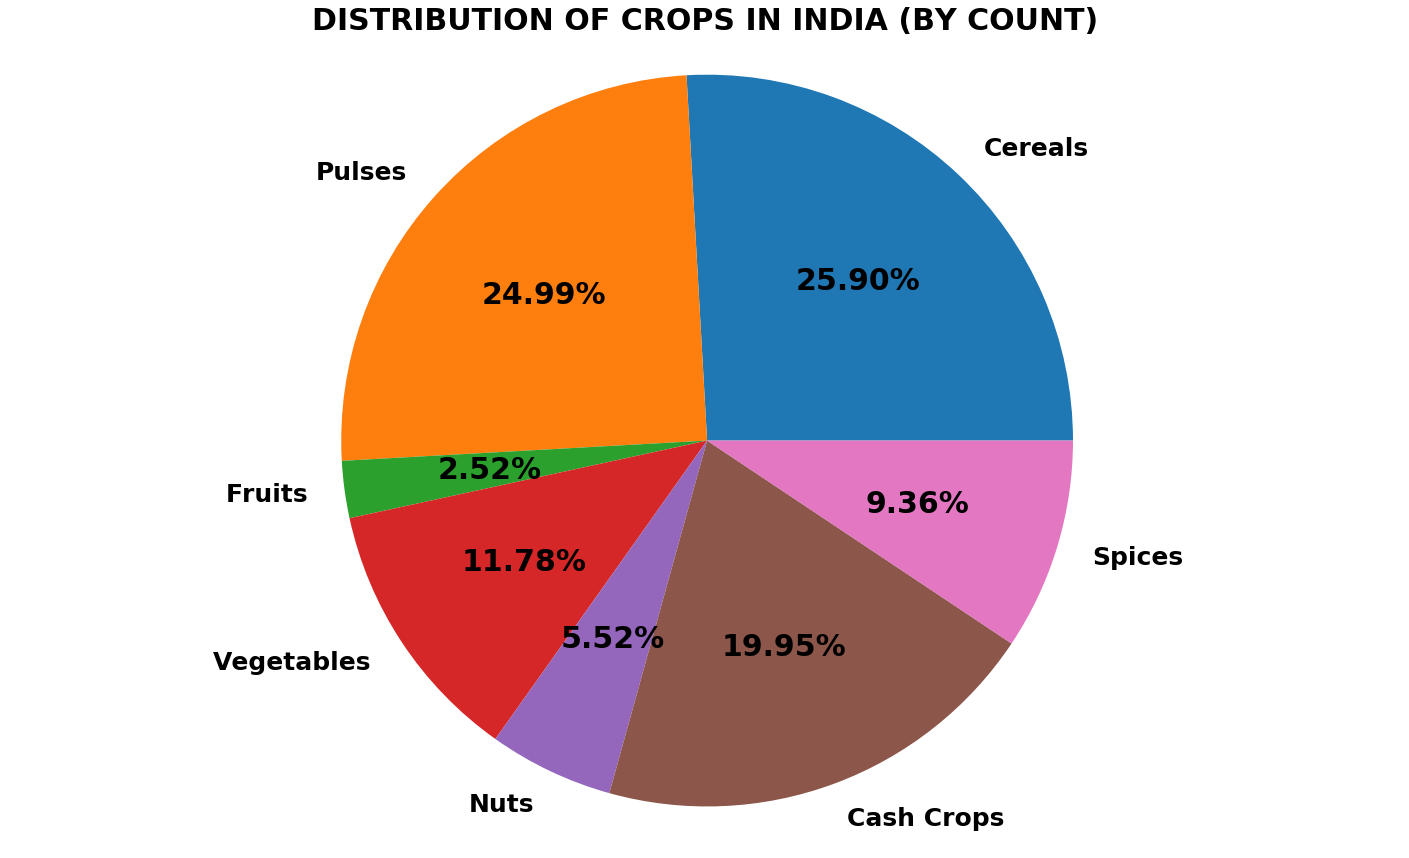

In [35]:
import matplotlib.pyplot as pp
pp.figure(figsize=(25,15))
w,t,at = pp.pie(crop_count,labels=crops,autopct='%.2f%%')
pp.setp(at,size=30,weight='bold')
pp.setp(t,size=25,weight='bold')
pp.axis('equal')
pp.title("DISTRIBUTION OF CROPS IN INDIA (BY COUNT)",size=30,loc='center',weight='bold')
pp.show()

In [36]:
print(data_crops.columns)
data_crops = data_crops.drop(columns="Crop_Type")
print(data_crops.columns)

Index(['State_Name', 'District_Name', 'Crop_Year', 'Season', 'Crop', 'Area',
       'Production', 'Rainfall', 'Crop_Type'],
      dtype='object')
Index(['State_Name', 'District_Name', 'Crop_Year', 'Season', 'Crop', 'Area',
       'Production', 'Rainfall'],
      dtype='object')


### While converting the non-numericdata (categorical) to numeric data.....we ought to compare one-hot encoding and binary encoding and label encoding.
**Fields considered are**
* states
* districts
* crop
* seasons

## ONE-HOT ENCODING
![ONE-HOT Encoding](/images/OH.png) 

## LABEL ENCODING
![Label Encoding](/images/Label.png)

## BINARY ENCODING
### It is a variation added to label encoding. If the labels encoded to the categorical features which are in the decimal format (ex: 5) when converted to Binary format (ex: 5 -> 101) then it is called as Binary Encoding.

# ONE HOT ENCODING

In [37]:
ohe = ce.OneHotEncoder()
d_1 = ohe.fit_transform(data_crops)
d_1.shape

(246091, 813)

# BINARY ENCODING

In [38]:
be = ce.BinaryEncoder()
data = be.fit_transform(data_crops)   #if none columns are specified the method considers all the string attributes by default
data.shape

(246091, 34)

# LABEL ENCODING

In [39]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
state = data_crops.State_Name
state = le.fit_transform(state)
data_crops = data_crops.assign(State_Name = state)
district = data_crops.District_Name
district = le.fit_transform(district)
data_crops = data_crops.assign(District_Name = district)

season = data_crops.Season
season = le.fit_transform(season)
data_crops = data_crops.assign(Season = season)

crop = data_crops.Crop
crop = le.fit_transform(crop)
data_crops = data_crops.assign(Crop = crop)
print(data_crops)



        State_Name  District_Name  Crop_Year  Season  Crop      Area  \
0                0            427       2000       1     2    1254.0   
1                0            427       2000       1    74       2.0   
2                0            427       2000       1    95     102.0   
3                0            427       2000       4     7     176.0   
4                0            427       2000       4    22     720.0   
...            ...            ...        ...     ...   ...       ...   
246086          32            471       2014       3    95     306.0   
246087          32            471       2014       3   102     627.0   
246088          32            471       2014       4   106     324.0   
246089          32            471       2014       5    95  279151.0   
246090          32            471       2014       5   102     175.0   

        Production  Rainfall  
0           2000.0    1208.4  
1              1.0    1208.4  
2            321.0    1208.4  
3          

In [40]:
print(data.columns)

Index(['State_Name_0', 'State_Name_1', 'State_Name_2', 'State_Name_3',
       'State_Name_4', 'State_Name_5', 'State_Name_6', 'District_Name_0',
       'District_Name_1', 'District_Name_2', 'District_Name_3',
       'District_Name_4', 'District_Name_5', 'District_Name_6',
       'District_Name_7', 'District_Name_8', 'District_Name_9',
       'District_Name_10', 'Crop_Year', 'Season_0', 'Season_1', 'Season_2',
       'Season_3', 'Crop_0', 'Crop_1', 'Crop_2', 'Crop_3', 'Crop_4', 'Crop_5',
       'Crop_6', 'Crop_7', 'Area', 'Production', 'Rainfall'],
      dtype='object')


### ASSIGNING COLUMNS TO X AND Y
**812 COLUMN COUNT LEAD TO MORE COMPUTATIONAL EFFORT**

**33 COLUMNS ARE LESS COMAPRED TO 812 BUT NOT COMPLETEY EFFICIENT** :camel:

**COLUMN COUNT WILL BE REMAINED SAME BUT INORDER TO AVOID THE PROBLEM OF NUMBER SEQUENCING WHICH INTRODUCES RELATION/COMPARISION BETWEEN DIFFERENT TRAINING EXAMPLES, WE APPLY "FEATURE SCALING" ALONG WITH LABEL ENCODING FOR THE CATEGORICAL ATTRIBUTES TO MAKE THE TRAINING EXAMPLES INDEPENDENT OF EACH OTHER.**

In [41]:
Y = data_crops.iloc[:,6]
X = data_crops.drop(['Production'],axis = 'columns')
Y = Y.to_frame()
print(type(X))
print(type(Y))


<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


In [42]:
print(X.columns)
print(Y.columns)

Index(['State_Name', 'District_Name', 'Crop_Year', 'Season', 'Crop', 'Area',
       'Rainfall'],
      dtype='object')
Index(['Production'], dtype='object')


### Finding the missing values

### Visualizing the missing values as a matrix

Production    3730
dtype: int64
State_Name          0
District_Name       0
Crop_Year           0
Season              0
Crop                0
Area                0
Rainfall         8556
dtype: int64


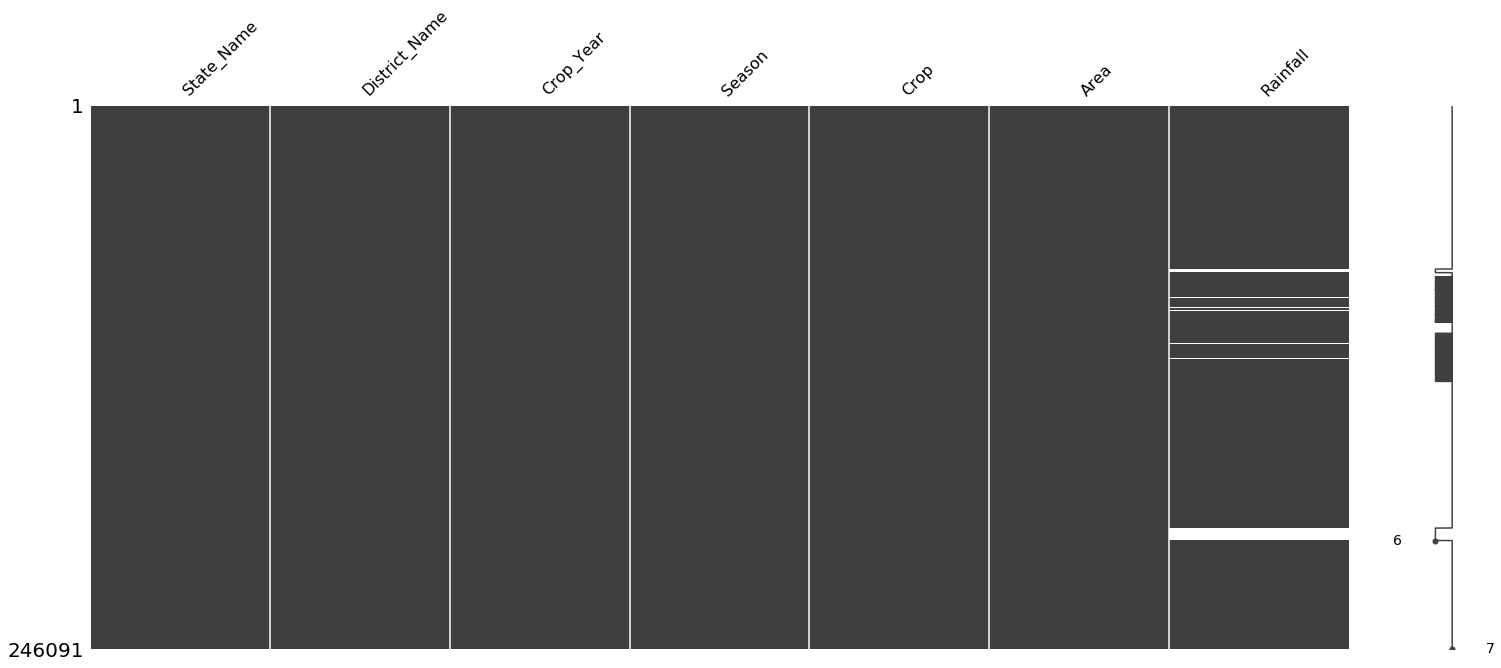

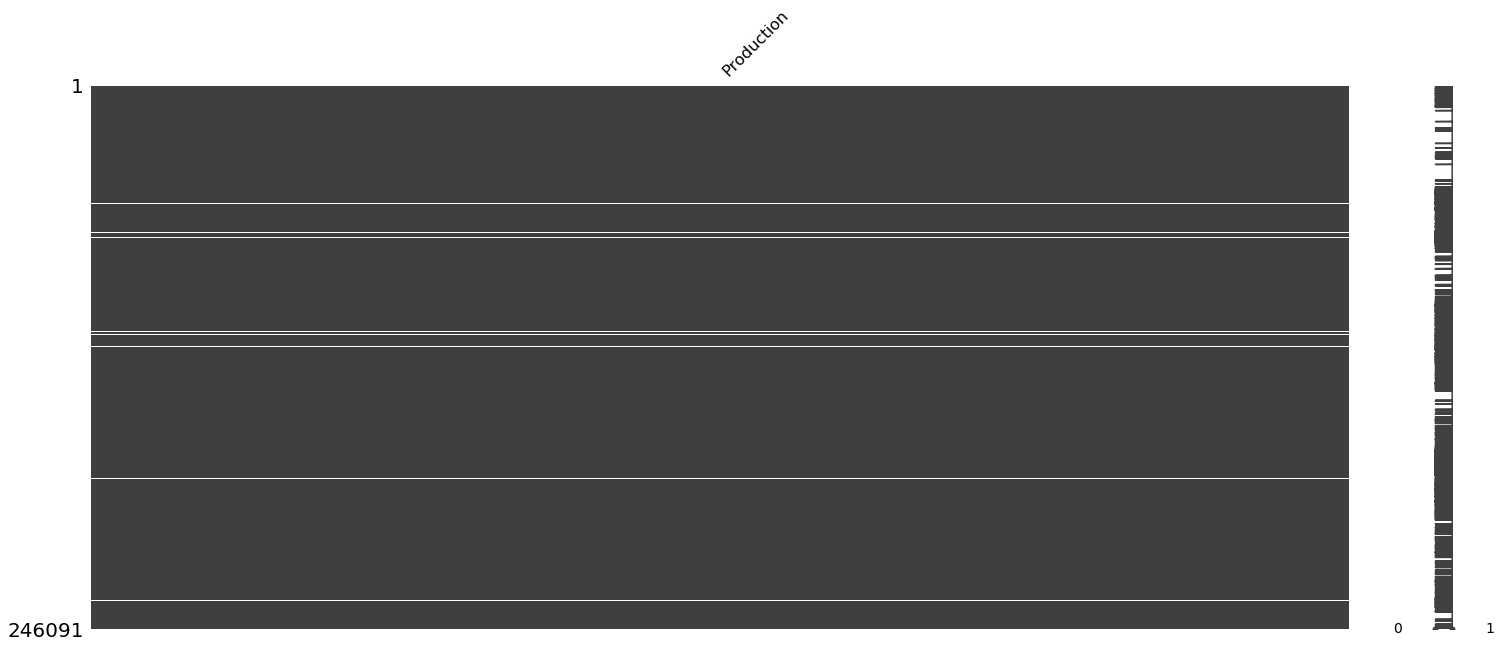

In [43]:
import missingno as msno

msno.matrix(X)
msno.matrix(Y)

print(Y.isnull().sum())
print(X.isnull().sum())


### we have missing values in production and Rainfall(the white lines in the graph)'''

### Replacing the missing values in production and Rainfall with their respective columns "mean".

In [44]:
X.Rainfall.fillna(X.Rainfall.mean(),inplace=True)
Y.Production.fillna(Y.Production.mean(),inplace=True)
Y_rep = Y.copy()
print(type(Y_rep))
print(Y_rep)
print(X.shape)

<class 'pandas.core.frame.DataFrame'>
        Production
0           2000.0
1              1.0
2            321.0
3            641.0
4            165.0
...            ...
246086       801.0
246087       463.0
246088     16250.0
246089    597899.0
246090        88.0

[246091 rows x 1 columns]
(246091, 7)


In [45]:
#splitting the data into X and Y

X_train,X_test,Y_train,Y_test = train_test_split(X, Y, train_size = 0.8, test_size = 0.2,random_state = 0)


from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)
Y_train = scaler.fit_transform(Y_train)
Y_test = scaler.fit_transform(Y_test)
print(type(Y_train))
print("Feature Scaling -> ready for training")


<class 'numpy.ndarray'>
Feature Scaling -> ready for training


# RANDOM FOREST REGRESSOR

>* **It generates multi decision trees from which each decison tree uses a part of data sample and predicts the result. Then the result which was achieved by maximum number of trees is considered as the final prediction.**
>* **Random forest is a Supervised Learning algorithm which uses ensemble learning method for classification and regression**
>* **Random forest is a bagging technique and the trees in random forests run in parallel without any interactions.** 


In [46]:
# RANDOM FOREST REGRESSOR
from sklearn.ensemble import RandomForestRegressor   

# TRAINING
model_rr = RandomForestRegressor(n_estimators = 1000,random_state = 0)
model_rr.fit(X_train, np.ravel(Y_train))

# TESTING
rr_prediction = model_rr.predict(X_test)


# DECISION TREE REGRESSOR

>* **Decision trees are constructed through an algorithmic approach that identifies ways to split the data set based on different conditions.**
>* **It is one of the most widely used practical methods for supervised learning.**
>* **These are non-parametric method used for both classification and regression.**

In [47]:
# DECISION TREE REGRESSOR
from sklearn.tree import DecisionTreeRegressor as dtr

# TRAINING
model_dtr = dtr(max_depth=4)
model_dtr.fit(X_train,np.ravel(Y_train))

# TESTING
dtr_prediction = model_dtr.predict(X_test)


# GRADIENT BOOST REGRESSION

>* **Gradient boosting method converts the weak learners into strong learners by boosting their capability.**
>* **A sequential process of learning from the previous trees and increasing the model accuracy.**
>* **One of the most used and efficient method.**

In [48]:
# GRADIENT BOOST REGRESSION
from sklearn.ensemble import GradientBoostingRegressor as gbr

# TRAINING
model_gbr = gbr(n_estimators=1000,max_depth=4,random_state=0)
model_gbr.fit(X_train, np.ravel(Y_train))

# TESTING
gbr_prediction = model_gbr.predict(X_test)


In [49]:
def accuracy(original,prediction):
    original = original.reshape(-1,1)
    prediction = prediction.reshape(-1,1)
    original = scaler.inverse_transform(original)
    prediction = scaler.inverse_transform(prediction)
    score = r2_score(original,prediction)
    return score

In [50]:
score_rr = accuracy(Y_test,rr_prediction)
print(f"The R^2 of the Random Forest Regressor {score_rr}\n Accuracy of the RFR is {score_rr*100} \n")

score_gbr = accuracy(Y_test,gbr_prediction)
print(f"The R^2 of the Gradient Boosting Regressor {score_gbr}\n Accuracy of the GBR is {score_gbr*100} \n")

score_dtr = accuracy(Y_test,dtr_prediction)
print(f"The R^2 of the Decision Tree Regressor {score_dtr}\n Accuracy of the DTR is {score_dtr*100} ")

The R^2 of the Random Forest Regressor 0.8857244743665621
 Accuracy of the RFR is 88.5724474366562 

The R^2 of the Gradient Boosting Regressor 0.8411098507596291
 Accuracy of the GBR is 84.1109850759629 

The R^2 of the Decision Tree Regressor 0.7131107393986301
 Accuracy of the DTR is 71.31107393986301 


## Accuracy
### Random Forest Regressor(RFR) with 0.88 of R^2 has proved to be efficient with the Test data when comapred to DTR and GBR